In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'TSLA', 'NFLX', 'ADBE', 'INTC']

In [3]:
data = yf.download(tickers, period = '6mo')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [45]:
benchmark = yf.download('^GSPC', period='6mo')['Close']

[*********************100%***********************]  1 of 1 completed


In [20]:
returns = (data.iloc[-1] / data.iloc[0]) - 1
#return1 = pd.Series(returns)

In [22]:
top_gainers = returns.sort_values(ascending=False)

In [24]:
top_gainers['Close']

Ticker
NVDA     0.465361
NFLX     0.214633
MSFT     0.186683
META     0.081807
INTC     0.020207
GOOGL    0.009523
AMZN    -0.016906
AAPL    -0.067276
ADBE    -0.154720
TSLA    -0.204180
dtype: float64

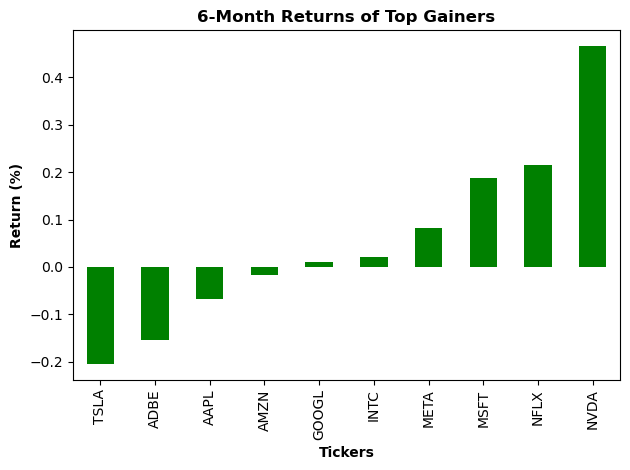

In [67]:
top_gainers['Close'].sort_values().plot(kind='bar', color='green')
plt.title('6-Month Returns of Top Gainers',fontweight='bold')
plt.ylabel('Return (%)',fontweight='bold')
plt.xlabel('Tickers',fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

In [26]:
num_assets = int(input("How many top gainers to include in portfolio? "))
selected = top_gainers['Close'].head(num_assets).index.tolist()

print("Selected Tickers:", selected)


How many top gainers to include in portfolio?  5


Selected Tickers: ['NVDA', 'NFLX', 'MSFT', 'META', 'INTC']


In [28]:
price_data = yf.download(selected, period = '6mo')['Close']

[*********************100%***********************]  5 of 5 completed


In [29]:
daily_returns = price_data.pct_change().dropna()

In [30]:
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [35]:
def portfolio_performance(weights):
    port_return = np.sum(mean_returns * weights) * 252
    port_volitility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix*252,weights)))
    sharpe_ratio = port_return / port_volitility
    return -sharpe_ratio 

In [36]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(selected)))

# Initial guess
initial_weights = len(selected) * [1. / len(selected)]

# Run optimization
optimized = minimize(portfolio_performance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = optimized.x

In [38]:
normalized = price_data / price_data.iloc[0]
portfolio = (normalized * opt_weights).sum(axis=1)

In [41]:
returns = portfolio.pct_change().dropna()
annual_return = returns.mean()*252
annual_volitility = returns.std() * (252 ** 0.5)
sharpe = annual_return / annual_volitility

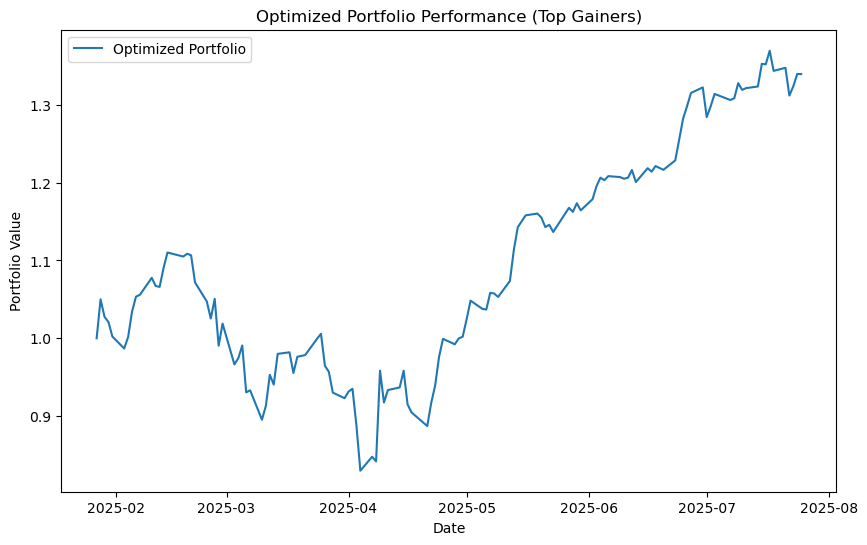

In [42]:
plt.figure(figsize=(10,6))
plt.plot(portfolio,label='Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Optimized Portfolio Performance (Top Gainers)')
plt.legend()
plt.show()

In [46]:
benchmark = benchmark.dropna()
benchmark_normalize = benchmark / benchmark.iloc[0]

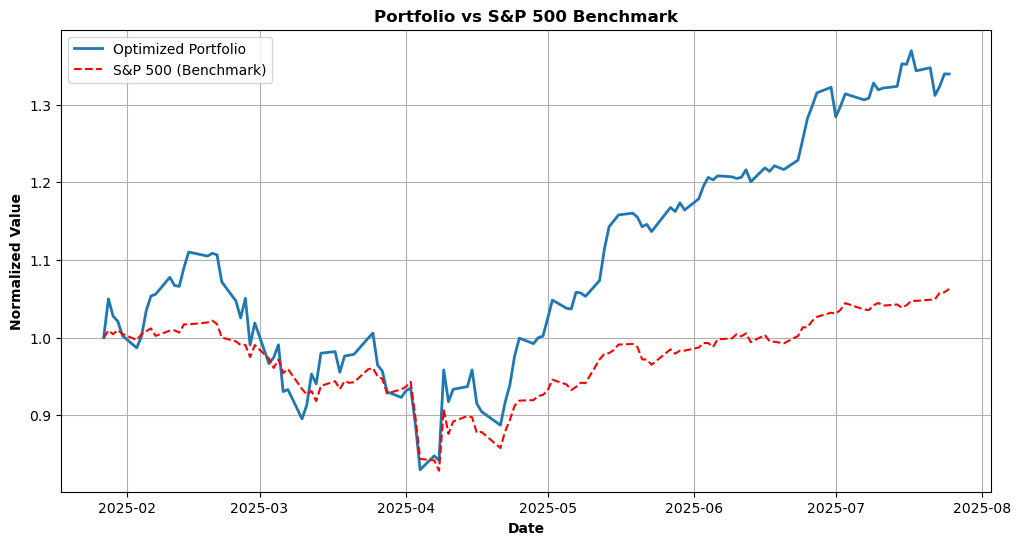

In [53]:
plt.figure(figsize=(12,6))
plt.plot(portfolio, label='Optimized Portfolio', linewidth=2)
plt.plot(benchmark_normalize, label='S&P 500 (Benchmark)', linestyle='--', color = 'r')
plt.title('Portfolio vs S&P 500 Benchmark',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Normalized Value',fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_volitility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
outperformance = outperformance.item()
print(f"Portfolio outperformed benchmark by: {outperformance:.2f}% over 6 months")

Annualized Return: 67.05%
Annualized Volatility: 39.44%
Sharpe Ratio: 1.70
Portfolio outperformed benchmark by: 27.66% over 6 months
